In [ ]:
import jax.numpy as np
from jax import grad
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax import random # stax initialization uses jax.random
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, Softplus # neural network layers
import matplotlib.pyplot as plt # visualization

import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 

In [ ]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)

rng = random.PRNGKey(0)
in_shape = (-1, 1,)
out_shape, net_params = net_init(rng, in_shape)

In [ ]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Softplus,
    Dense(40), Softplus,
    Dense(1)
)

rng = random.PRNGKey(0)
in_shape = (-1, 1,)
out_shape, net_params = net_init(rng, in_shape)

In [ ]:
alpha = .1

def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [ ]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K=20
for i in range(20000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

In [ ]:
# batch the inference across K=100
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1))
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,3):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

Relu loss: 0.05396223068237305
Softplus 1 loss: 0.5997022390365601
Softplus 10 loss: 0.03531594201922417
Softplus 100 loss: 0.06312423944473267
Softplus 1000 loss: 0.06311879307031631
Softplus 10000 loss: 0.09852041304111481


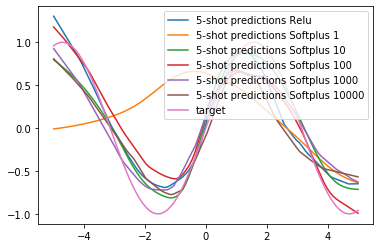

In [54]:
import jax.numpy as np
from jax import grad
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax import random # stax initialization uses jax.random
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, Softplus # neural network layers
import matplotlib.pyplot as plt # visualization

import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 

alpha = .1

def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2


def network(activation):
    # Use stax to set up network initialization and evaluation functions
    net_init, net_apply = stax.serial(
        Dense(40), activation,
        Dense(40), activation,
        Dense(1)
    )
    return net_init, net_apply

def elementwise(fun, **fun_kwargs):
    """Layer that applies a scalar function elementwise on its inputs."""
    init_fun = lambda rng, input_shape: (input_shape, ())
    apply_fun = lambda params, inputs, **kwargs: fun(inputs, **fun_kwargs)
    return init_fun, apply_fun

def softplus_beta(beta, x):
    return np.logaddexp(beta*x, 0) / beta


class MAML:
    def __init__(self, activation=Relu):
        self.activation = activation
        self.net_init, self.net_apply = network(activation)
        self.optimizer = optimizers.adam(step_size=1e-3)
        
        rng = random.PRNGKey(0)
        in_shape = (-1, 1,)
        self.out_shape, self.net_params = self.net_init(rng, in_shape)
        
    def loss(self, params, inputs, targets):
        # Computes average loss for the batch
        predictions = self.net_apply(params, inputs)
        return np.mean((targets - predictions)**2)

    def inner_update(self, p, x1, y1):
        grads = grad(self.loss)(p, x1, y1)
        inner_sgd_fn = lambda g, state: (state - alpha*g)
        return tree_multimap(inner_sgd_fn, grads, p)

    def maml_loss(self, p, x1, y1, x2, y2):
        p2 = self.inner_update(p, x1, y1)
        return self.loss(p2, x2, y2)

    # vmapped version of maml loss.
    # returns scalar for all tasks.
    def batch_maml_loss(self, p, x1_b, y1_b, x2_b, y2_b):
        task_losses = vmap(partial(self.maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
        return np.mean(task_losses)
    
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, x1, y1, x2, y2):
        _, opt_update, get_params = self.optimizer
        p = get_params(opt_state)
        g = grad(self.batch_maml_loss)(p, x1, y1, x2, y2)
        l = self.batch_maml_loss(p, x1, y1, x2, y2)
        return opt_update(i, g, opt_state), l


    def train(self, epoch=20000, num_task=4, K=20):

        opt_init, opt_update, get_params = self.optimizer
        opt_state = opt_init(self.net_params)

        np_batched_maml_loss = []
        for i in range(epoch):
            x1_b, y1_b, x2_b, y2_b = sample_tasks(num_task, K)
            opt_state, l = self.step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
            np_batched_maml_loss.append(l)
            #if i % 1000 == 0:
                #print("iter: " + str(i))
        self.net_params = get_params(opt_state)

        return self.net_params, self.net_apply
    
    def predict(self, inputs):
        return vmap(partial(self.net_apply, self.net_params))(inputs)
    
    
def main1():
    # batch the inference across K=100
    xrange_inputs = np.linspace(-5,5,100).reshape((100, 1))
    targets = np.sin(xrange_inputs)

    # ReLu
    maml1 = MAML(Relu)
    net_params1, net_apply1 = maml1.train()
    predictions1 = maml1.predict(xrange_inputs)
    # Softplus
    softplus1 = elementwise(partial(softplus_beta, 1))   
    maml2 = MAML(softplus1)
    net_params2, net_apply2 = maml2.train()
    predictions2 = maml2.predict(xrange_inputs)


    plt.plot(xrange_inputs, predictions1, label='pre-update predictions relu')
    plt.plot(xrange_inputs, predictions2, label='pre-update predictions softplus')
    plt.plot(xrange_inputs, targets, label='target')

    x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
    y1 = 1. * onp.sin(x1 + 0.)

    k = 5
    for i in range(1,k):
        net_params1 = maml1.inner_update(net_params1, x1, y1)
    predictions = vmap(partial(net_apply1, net_params1))(xrange_inputs)
    loss = maml1.loss(net_params1, xrange_inputs, targets)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions Relu'.format(k))
    plt.legend()

    for i in range(1,k):
        net_params2 = maml2.inner_update(net_params2, x1, y1)
    predictions = vmap(partial(net_apply2, net_params2))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions SoftPlus'.format(k))
    plt.legend()
    
    plt.savefig('maml_plot.png')
    

    
if __name__ == "__main__":
        
    # batch the inference across K=100
    xrange_inputs = np.linspace(-5,5,100).reshape((100, 1))
    targets = np.sin(xrange_inputs)
    
    activations = {"Relu": Relu}
    # get different softplus activation function by different beta
    betas = [1, 10, 100, 1000, 10000]
    for beta in betas:
        softplus = elementwise(partial(softplus_beta, beta)) 
        activations["Softplus " + str(beta)] =  softplus
       
    for activation in activations:            
        maml = MAML(activations[activation])
        net_params, net_apply = maml.train()
        predictions = maml.predict(xrange_inputs)

        x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
        y1 = 1. * onp.sin(x1 + 0.)

        k = 5
        for i in range(1,k):
            net_params = maml.inner_update(net_params, x1, y1)
        predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
        loss = maml.loss(net_params, xrange_inputs, targets)
        print("{} loss: {}".format(activation, loss))
        plt.plot(xrange_inputs, predictions, label='{}-shot predictions {}'.format(k, activation))
        plt.legend()
    
            
    plt.plot(xrange_inputs, targets, label='target')
    plt.legend()
    plt.savefig('maml_plot2.png')

    
    
    
    